In [22]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [23]:
data = load_diabetes()
X = data.data
y = data.target

# XGboostDecisionTree

In [24]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class XGboostDecisionTree:
    def __init__(self, max_depth = None, min_sample_split = None , reg_lambda = None, gamma = None, min_child_weight = None):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.root = None

    def best_split(self, X , G, H):
        features = X.shape[1]
    
        best_gain = -float('inf')
        best_threshold = None
        best_feature = None

        
        for feature in range(features):
            '''
            The formula used for info gain
            gradient(G) = y_perd − y
            hessian(H) = 1 (constant)
            gain = 1/2[((G_L)**2 / (H_L + lambda)) + ((G_R)**2 / (H_R + lambda)) - ((G_L + G_R)**2 /( H_L + H_R + lambda))] - Gamma
            '''
            
            sorted_idx = np.argsort(X[:,feature])
            sorted_X = X[:, feature][sorted_idx]
            sorted_G = G[sorted_idx]
            sorted_H = H[sorted_idx]

            total_G = np.sum(sorted_G)
            total_H = np.sum(sorted_H)
            
            n = len(sorted_X)
            G_L = 0
            H_L = 0
            for i in range(n - 1):
                if sorted_X[i] == sorted_X[i + 1]:
                    continue
                G_L += sorted_G[i]
                G_R = total_G - G_L

                H_L += sorted_H[i]
                H_R = total_H - H_L
                if H_L < self.min_child_weight or H_R < self.min_child_weight:
                    continue 

                gain = (((G_L)**2 / (H_L + self.reg_lambda)) + ((G_R)**2 / (H_R + self.reg_lambda)) - ((G_L + G_R)**2 /( H_L + H_R + self.reg_lambda))) / 2 - self.gamma

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = (sorted_X[i] + sorted_X[i+1]) / 2

        return best_gain, best_feature, best_threshold

           
    def build_tree(self, X, G , H, depth = 0):
        '''
        leaf value formula
        value = -gradient / (hessian  + lambda)
        '''
        n_samples = len(X)
        leaf_value = -np.sum(G) / (np.sum(H) + self.reg_lambda)

        gain, feature, threshold = self.best_split(X, G , H)

        if gain <= 0 or depth >= self.max_depth or n_samples < self.min_sample_split:
            return Node(value = leaf_value)

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left_X, left_G, left_H = X[left_mask], G[left_mask], H[left_mask]
        right_X, right_G, right_H = X[right_mask], G[right_mask], H[right_mask]

        left = self.build_tree(left_X, left_G, left_H, depth + 1)
        right = self.build_tree(right_X, right_G, right_H, depth + 1)

        return Node(
            feature = feature,
            threshold = threshold,
            left = left,
            right = right
        )
        
    def plot_tree(self,node ,dot = None, counter = [0]):
        if dot is None:
            dot = Digraph()
            dot.attr('node', shape = 'box')

        counter_id = str(counter[0])
        counter[0] += 1

        if node.value is not None:
                dot.node(counter_id, f'Leaf \n Value: {node.value :.2f}')
        else:
            dot.node(counter_id, f'X[{node.feature}] <= {node.threshold :.5f}')
            left_id = self.plot_tree(node.left, dot, counter)
            right_id = self.plot_tree(node.right, dot, counter)

            dot.edge(counter_id, left_id, label = 'True')
            dot.edge(counter_id, right_id, label = 'False')

        return counter_id


    def fit(self, X, gradient, hessian):
        self.root = self.build_tree(X, gradient, hessian)
        

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        predict = np.array([self.predict_one(i, self.root) for i in X])
        return predict
        

# XGBoost class

In [25]:
class XGBoost:
    def __init__(self, n_iter = 100, learning_rate = 0.01, max_depth = 3, min_sample_split = 2 , reg_lambda = 1.0, gamma = 0.0, min_child_weight = 1.0):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.trees= []
        self.loss_history = []

    def fit(self, X, y):
        y_pred = np.zeros_like(y)

        for i in range(self.n_iter):
            G = y_pred - y
            H = np.ones_like(y)

            tree = XGboostDecisionTree(
                max_depth= self.max_depth,
                min_sample_split= self.min_sample_split,
                reg_lambda= self.reg_lambda,
                gamma= self.gamma,
                min_child_weight= self.min_child_weight,
            )
            tree.fit(X, G , H)

            update = tree.predict(X)
            y_pred += self.learning_rate * update

            self.trees.append(tree)

            loss = np.mean(G ** 2)
            self.loss_history.append(loss)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        
        for tree in self.trees:
            y_pred +=  self.learning_rate * tree.predict(X)

        return y_pred


# utility functions

In [26]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Model execution

In [27]:
train_X, train_y, test_X, test_y = train_test_split(X, y, ratio = 0.6, shuffle = True, seed = 1)
model = XGBoost(n_iter = 100 , learning_rate = 0.4, max_depth= 2, min_sample_split=20,reg_lambda= 1, gamma=0.2, min_child_weight=4.1)
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
print('R2 score = ' , r2_score(test_y, y_pred))

R2 score =  0.5401849584348922


# Loss curve

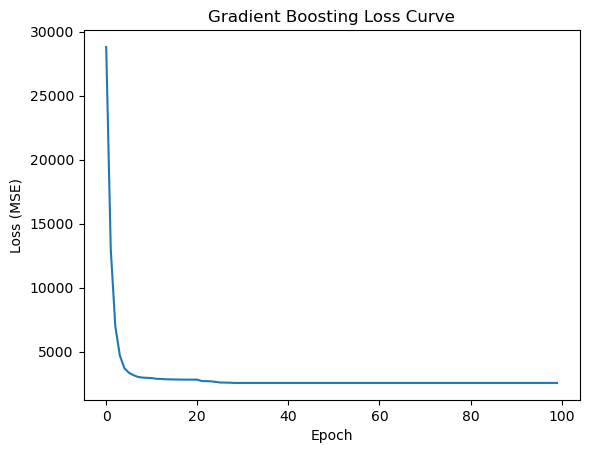

In [28]:
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Gradient Boosting Loss Curve")
plt.show()

# some of the decision trees inside the model.

### tree no. 1

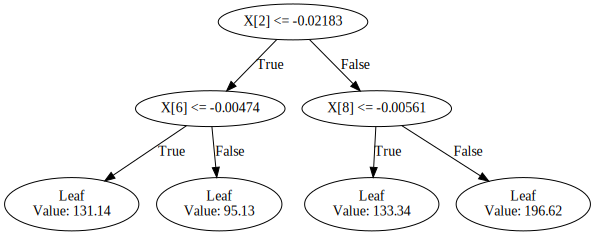

In [29]:
dot = Digraph()
tree = XGboostDecisionTree()
tree.plot_tree(model.trees[0].root , dot)
dot

### tree no. 10

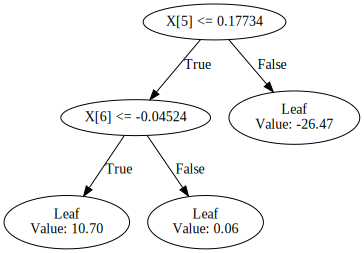

In [30]:
dot = Digraph()
tree = XGboostDecisionTree()
tree.plot_tree(model.trees[9].root , dot)
dot

### tree no. 50

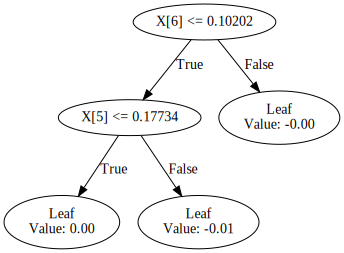

In [31]:
dot = Digraph()
tree = XGboostDecisionTree()
tree.plot_tree(model.trees[49].root , dot)
dot